# IF3170 Artificial Intelligence | Tugas Besar 1
Notebook ini digunakan untuk pengujian terhadap implementasi model FFNN.

Nomor Kelompok: 57

Anggota Kelompok:
- Aland Mulia Pratama (13522124)
- Christian Justin Hendrawan (13522135)
- Albert Ghazaly (13522150)

In [12]:
# Import libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from ffnn.model import FFNN
plt.style.use('ggplot')

# 1. Memuat Dataset MNIST_784

Dataset **MNIST_784** adalah kumpulan data yang terdiri dari 70.000 gambar tulisan tangan angka (digit) dari 0 hingga 9 dengan dimensi 28x28 piksel yang telah diratakan menjadi vektor berdimensi 784. Dataset ini sering digunakan dalam bidang **computer vision** dan pembelajaran mesin untuk pengenalan pola dan klasifikasi.

Proses pengolahan data dilakukan melalui langkah-langkah berikut:

1. **Pembagian Data (Data Split)**

    Dataset dibagi menjadi data latih (training data) dan data uji (test data). Pembagian ini dilakukan dengan memisahkan 10.000 sampel sebagai data uji, sementara sisanya digunakan untuk pelatihan. Proses pembagian menggunakan fungsi train_test_split dengan rasio test_size=10,000, memastikan bahwa data uji tetap terdistribusi secara acak dan representatif.

2. **Normalisasi Data (Data Normalization)**

    Untuk meningkatkan performa model, data fitur (pixel values) dinormalisasi ke rentang [0,1] dengan membagi setiap nilai piksel dengan 255. Hal ini dilakukan untuk mengurangi skala besar pada data asli, sehingga mempercepat proses pembelajaran dan meningkatkan stabilitas optimasi.

3. **Pengkodean Label (One-Hot Encoding)**

    Target label, yang awalnya berupa integer (0-9), diubah menjadi representasi one-hot encoding. Proses ini dilakukan dengan menggunakan OneHotEncoder dari scikit-learn, di mana setiap label dikodekan sebagai vektor biner berdimensi 10. Contohnya, label 2 akan diubah menjadi [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. Teknik ini sangat penting dalam arsitektur jaringan saraf untuk memungkinkan model memprediksi probabilitas pada setiap kelas.

In [13]:
def load_mnist():
    print("Loading MNIST_784 dataset...")
    
    # Ambil dataset dari OpenML
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int')
    
    # Normalisasi data
    X = X / 255.0
    
    # Split dataset menjadi training dan testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42)
    
    # Reshape data untuk satu dimensi
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encoding untuk label
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    
    print(f"Dataset loaded: {X_train.shape[0]} training samples, "
          f"{X_test.shape[0]} test samples")
    print(f"Input dimension: {X_train.shape[1]}")
    print(f"Output classes: {y_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test


# 2. Analisis Data & Eksplorasi (EDA)

Pada bagian ini, kita melakukan **visualisasi awal data** untuk memahami bentuk dan struktur dataset MNIST yang digunakan. Visualisasi ini bertujuan untuk memastikan bahwa data yang akan kita proses memiliki representasi yang benar dan sesuai dengan tujuan analisis.

Dataset MNIST terdiri dari gambar angka tulisan tangan dari **0 hingga 9**, dengan ukuran piksel 28x28. Setiap angka direpresentasikan dalam bentuk **array berdimensi 784** yang dapat dirangkai ulang menjadi gambar aslinya.

Visualisasi dilakukan dengan menampilkan beberapa contoh data dalam bentuk gambar angka bersama dengan **label yang sesuai**. Gambar-gambar ini menunjukkan variasi dari setiap digit dan memberikan gambaran tentang distribusi data. Proses ini membantu kita memastikan bahwa **data piksel benar-benar membentuk angka**, serta memahami tantangan dalam membangun model FFNN untuk memprediksi **angka berdasarkan nilai pikselnya**.

In [14]:
def visualize_examples(X, y_onehot, n_examples=5):
    plt.figure(figsize=(15, 3))
    
    y = np.argmax(y_onehot, axis=1)
    
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Loading MNIST_784 dataset...
Dataset loaded: 60000 training samples, 10000 test samples
Input dimension: 784
Output classes: 10


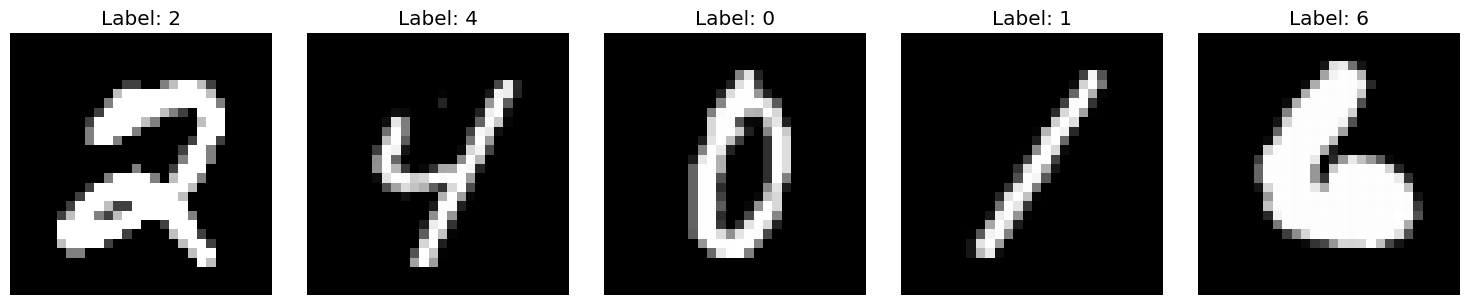

In [15]:
# Load dataset
X_train, X_test, y_train, y_test = load_mnist()

# Lakukan visualisasi contoh data
visualize_examples(X_train, y_train)

# 3. Pengujian Terhadap Implementasi FFNN (Feed Forward Neural Network)

Analisis ini bertujuan mengevaluasi pengaruh berbagai hyperparameter pada kinerja model FFNN. Pertama, dilakukan analisis pengaruh jumlah layer (depth) dan jumlah neuron per layer (width) terhadap hasil prediksi dan grafik loss pelatihan. Kedua, diuji pengaruh fungsi aktivasi hidden layer (kecuali softmax) pada hasil prediksi, grafik loss, serta distribusi bobot dan gradien. Ketiga, dilakukan analisis variasi learning rate untuk membandingkan hasil prediksi, grafik loss, dan distribusi bobot atau gradien. Keempat, pengaruh metode inisialisasi bobot dianalisis dengan membandingkan hasil prediksi, grafik loss, serta distribusi parameter. Terakhir, hasil prediksi model dibandingkan dengan library sklearn MLP menggunakan hyperparameter yang sama untuk menilai perbedaan kinerja.

In [16]:
def train_and_evaluate(X_train, X_test, y_train, y_test, 
                      hidden_layers, width_per_layer, 
                      hidden_activation='relu',    
                      output_activation='softmax',  
                      weight_initializer='normal', 
                      initializer_params=None,     
                      epochs=10, learning_rate=0.01, batch_size=128,
                      verbose=1):
    
    input_size = X_train.shape[1]  
    output_size = y_train.shape[1] 
    
    # Default initializer params jika tidak disediakan
    if initializer_params is None:
        initializer_params = {'std': 0.1}
    
    start_time = time.time()
    
    # Buat model
    model = FFNN(loss='categorical_crossentropy')
    
    # Tambahkan input layer
    if isinstance(width_per_layer, list):
        first_layer_width = width_per_layer[0]
    else:
        first_layer_width = width_per_layer
        
    model.add(input_size=input_size, output_size=first_layer_width, 
             activation=hidden_activation, 
             weight_initializer=weight_initializer, 
             **initializer_params)
    
    # Tambahkan hidden layers
    for i in range(1, hidden_layers):
        if isinstance(width_per_layer, list):
            prev_width = width_per_layer[i-1]
            current_width = width_per_layer[i]
        else:
            prev_width = width_per_layer
            current_width = width_per_layer
            
        model.add(input_size=prev_width, output_size=current_width,
                 activation=hidden_activation,
                 weight_initializer=weight_initializer, 
                 **initializer_params)
    
    # Tambahkan output layer dengan aktivasi yang ditentukan
    if isinstance(width_per_layer, list):
        last_hidden_width = width_per_layer[-1]
    else:
        last_hidden_width = width_per_layer
        
    model.add(input_size=last_hidden_width, output_size=output_size,
             activation=output_activation, 
             weight_initializer=weight_initializer, 
             **initializer_params)
    
    # Menunjukkan ringkasan model
    print(f"\nTraining model with {hidden_layers} hidden layers, width: {width_per_layer}")
    print(f"Activation: {hidden_activation} (hidden) | {output_activation} (output)")
    print(f"Initializer: {weight_initializer} with params {initializer_params}")
    model.summary()
    
    # Melakukan training model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=verbose,
    )
    
    # Hitung waktu training
    training_time = time.time() - start_time
    
    # Evaluasi model
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)
    
    # Tampilkan informasi akhir hanya jika verbose > 0
    if verbose > 0:
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'training_time': training_time,
        'depth': hidden_layers,
        'width': width_per_layer,
        'hidden_activation': hidden_activation,
        'output_activation': output_activation,
        'weight_initializer': weight_initializer,
        'initializer_params': initializer_params
    }

In [17]:
def plot_training_history_and_accuracy(history, model, X_test, y_test):
    # Plot training dan validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Evaluasi akurasi pada test set
    print("\nEvaluating on test set...")
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)

    # Plot akurasi
    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy'], [accuracy], color='skyblue')
    plt.title(f'Test Accuracy: {accuracy:.4f}')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [18]:
def visualize_predictions(model, X_test, y_test, n_examples=10):
    # Secara acak ambil contoh dari test set
    sample_indices = np.random.choice(len(X_test), n_examples, replace=False)
    X_samples = X_test[sample_indices]
    y_true_samples = np.argmax(y_test[sample_indices], axis=1)

    # Ambil prediksi pada contoh yang diambil
    y_pred_samples = model.forward(X_samples)
    y_pred_samples_classes = np.argmax(y_pred_samples, axis=1)

    # Visualisasi contoh dan prediksi
    plt.figure(figsize=(15, 4))
    for i in range(n_examples):
        plt.subplot(2, n_examples // 2, i + 1)
        plt.imshow(X_samples[i].reshape(28, 28), cmap='gray')

        color = 'green' if y_pred_samples_classes[i] == y_true_samples[i] else 'red'

        plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples_classes[i]}", 
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

print("Creating and training a FFNN model...")
# Train dengan arsitektur dan parameter yang dioptimalkan
results = train_and_evaluate(
    X_train_subset, X_test, y_train_subset, y_test,
    hidden_layers=2,              
    width_per_layer=[128, 64],    
    hidden_activation='relu',     
    output_activation='softmax',  
    weight_initializer='he',      
    initializer_params={},      
    epochs=20,
    learning_rate=0.01,
    batch_size=128,
    verbose=1             
)

# Ambil model dan history hasil training
model = results['model']
history = results['history']

Creating and training a FFNN model...

Training model with 2 hidden layers, width: [128, 64]
Activation: relu (hidden) | softmax (output)
Initializer: he with params {}
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386
Epoch 1/20 - loss: 1.9010, val_loss: 1.4435
Epoch 2/20 - loss: 1.1255, val_loss: 0.8807
Epoch 3/20 - loss: 0.7467, val_loss: 0.6548
Epoch 4/20 - loss: 0.5893, val_loss: 0.5503
Epoch 5/20 - loss: 0.5078, val_loss: 0.4908
Epoch 6/20 - loss: 0.4574, val_loss: 0.4499
Epoch 7/20 - loss: 0.4225, val_loss: 0.4246
Epoch 8/20 - loss: 0.3963, val_loss: 0.4004
Epoch 9/20 - loss: 0.3753, val_loss: 0.3802
Epoch 10/20 - loss: 0.3587, val_loss: 0.3666
Epoch 11/20 - loss: 0.3443, val_loss: 0.3597
Epoch 12/20 - loss: 0.3325, v


Evaluating on test set...


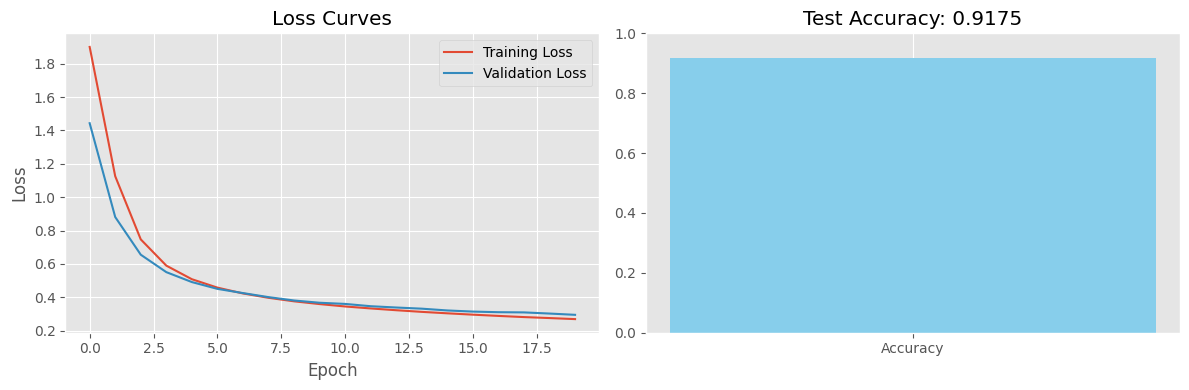

In [20]:
# Plot history training dan akurasi
plot_training_history_and_accuracy(history, model, X_test, y_test)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors
Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


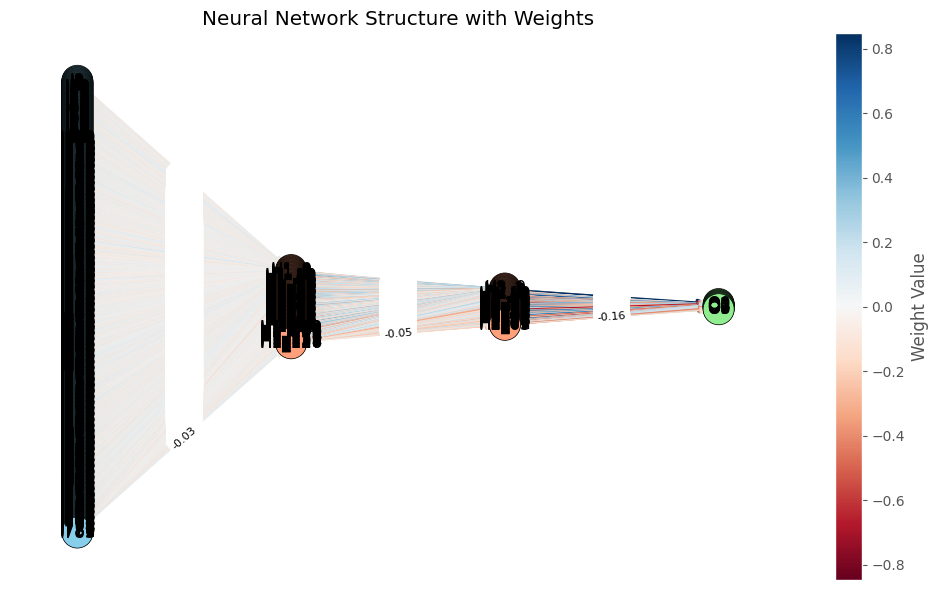

In [21]:
print("\nVisualizing network structure...")
model.visualize_network(figsize=(10, 6))


Visualizing weight distributions...


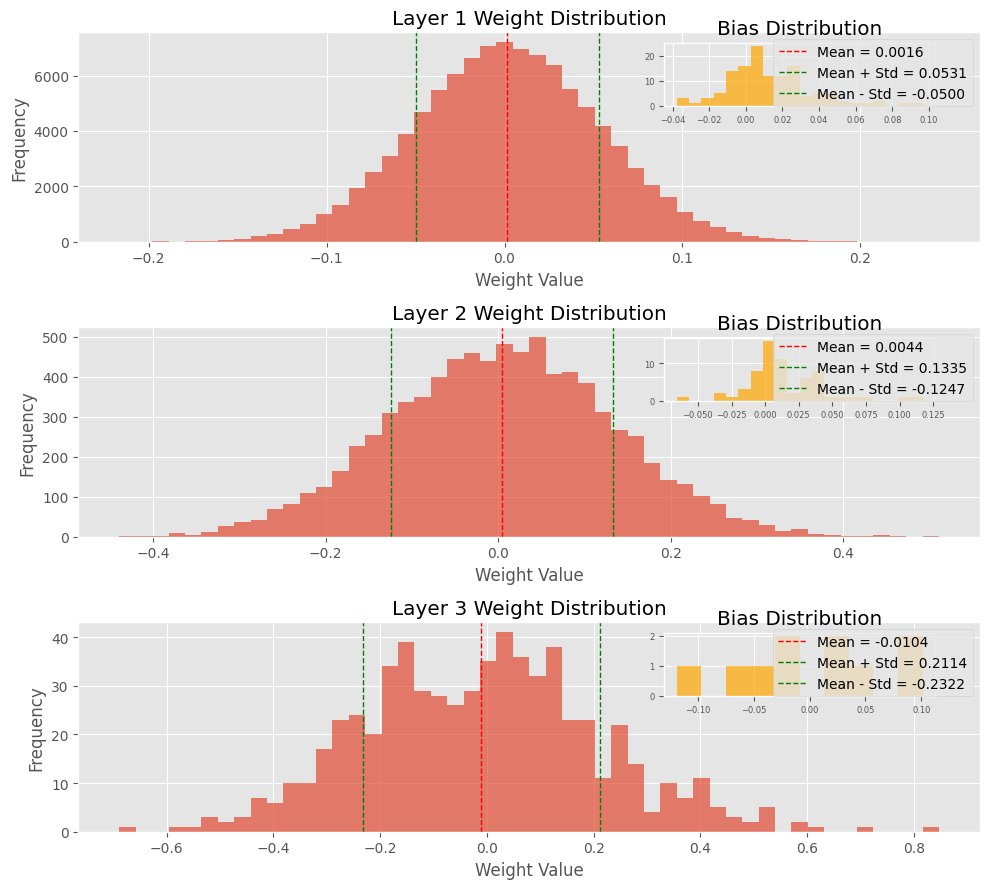

In [22]:
print("\nVisualizing weight distributions...")
model.visualize_weight_distribution()


Visualizing gradient distributions...


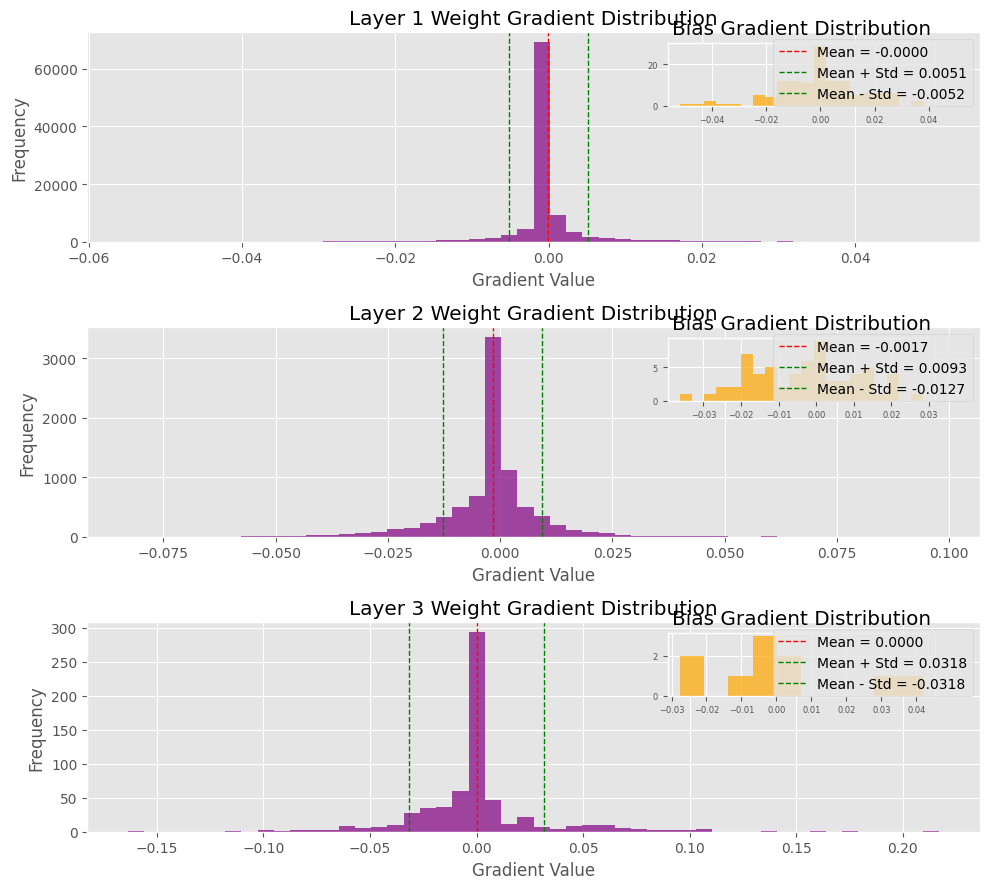

In [23]:
print("\nVisualizing gradient distributions...")
model.visualize_gradient_distribution()


Visualizing model predictions...


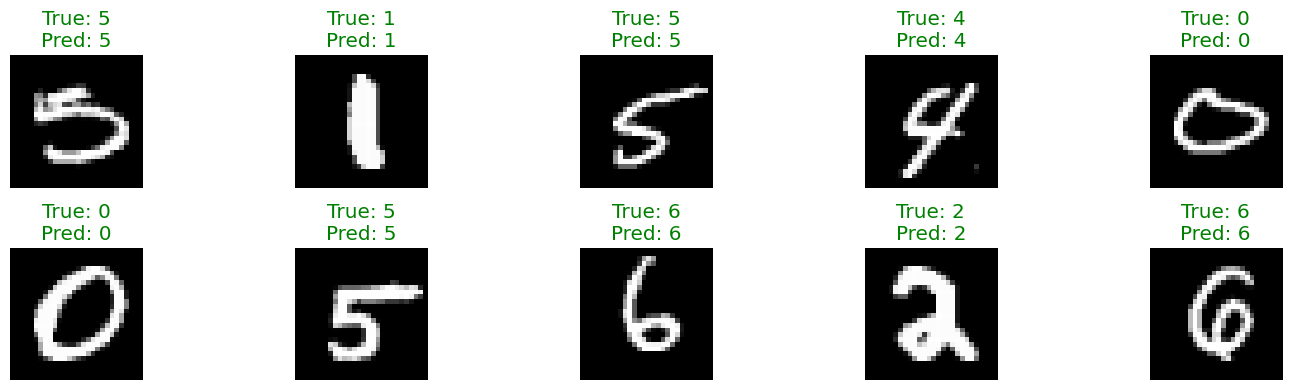

In [24]:
# Visualisasi prediksi
print("\nVisualizing model predictions...")
visualize_predictions(model, X_test, y_test, n_examples=10)

## a) Pengaruh depth (banyak layer) dan width (banyak neuron per layer)
Pada analisis ini, model FFNN akan diuji dengan 3 variasi kombinasi width (jumlah neuron per layer) dengan jumlah layer (depth) tetap, serta 3 variasi kombinasi depth (jumlah layer) dengan jumlah neuron (width) pada setiap layer tetap. Tujuan dari analisis ini adalah untuk:
- Membandingkan hasil akhir prediksi dari setiap variasi kombinasi depth dan width.
- Membandingkan grafik loss selama pelatihan untuk menilai pengaruh konfigurasi arsitektur terhadap proses konvergensi model.

### I) Depth

#### i) 1 Layer

In [ ]:
# Set parameters for the model
hidden_layers = 1  # Depth of the model (1 hidden layer)
width_per_layer = 64  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_d1 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

# Print results
print(f"Test Accuracy: {results_d1['accuracy']:.4f}")
print(f"Training Time: {results_d1['training_time']:.2f} seconds")



Training model with 1 hidden layers, width: 64
Neural Network Architecture Summary
Total layers: 2

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 50890
Epoch 1/10 - loss: 1.4194, val_loss: 0.8594
Epoch 2/10 - loss: 0.6865, val_loss: 0.5705
Epoch 3/10 - loss: 0.5174, val_loss: 0.4726
Epoch 4/10 - loss: 0.4467, val_loss: 0.4229
Epoch 5/10 - loss: 0.4069, val_loss: 0.3923
Epoch 6/10 - loss: 0.3809, val_loss: 0.3716
Epoch 7/10 - loss: 0.3623, val_loss: 0.3562
Epoch 8/10 - loss: 0.3477, val_loss: 0.3442
Epoch 9/10 - loss: 0.3358, val_loss: 0.3333
Epoch 10/10 - loss: 0.3257, val_loss: 0.3256
[==============================>]
Test accuracy: 0.9086
Training time: 6.18 seconds
Test Accuracy: 0.9086
Training Time: 6.18 seconds


: 

: 

: 

: 

: 


Evaluating on test set...


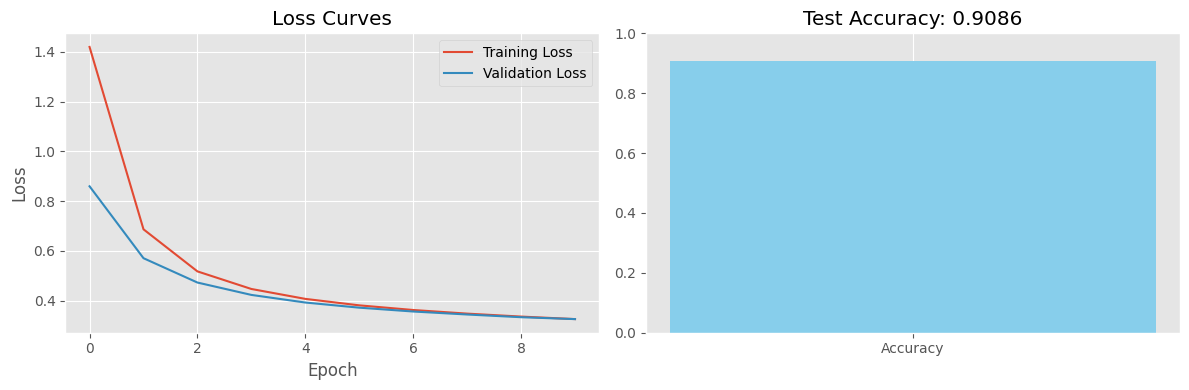

: 

: 

: 

: 

: 

In [ ]:
plot_training_history_and_accuracy(
    history=results_d1['history'],
    model=results_d1['model'],
    X_test=X_test,
    y_test=y_test
)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors


Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


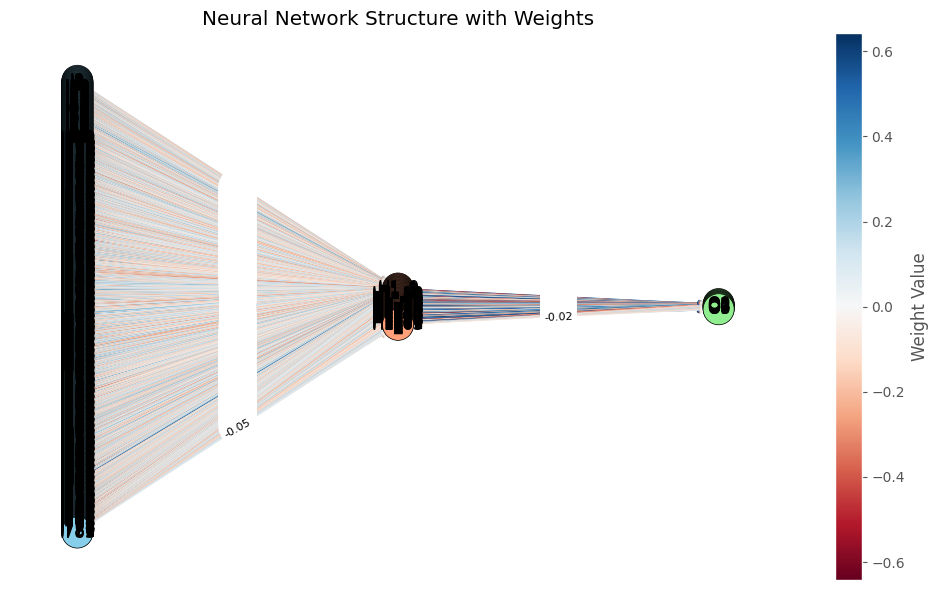

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing network structure...")
results_d1['model'].visualize_network(figsize=(10, 6))


Visualizing weight distributions...


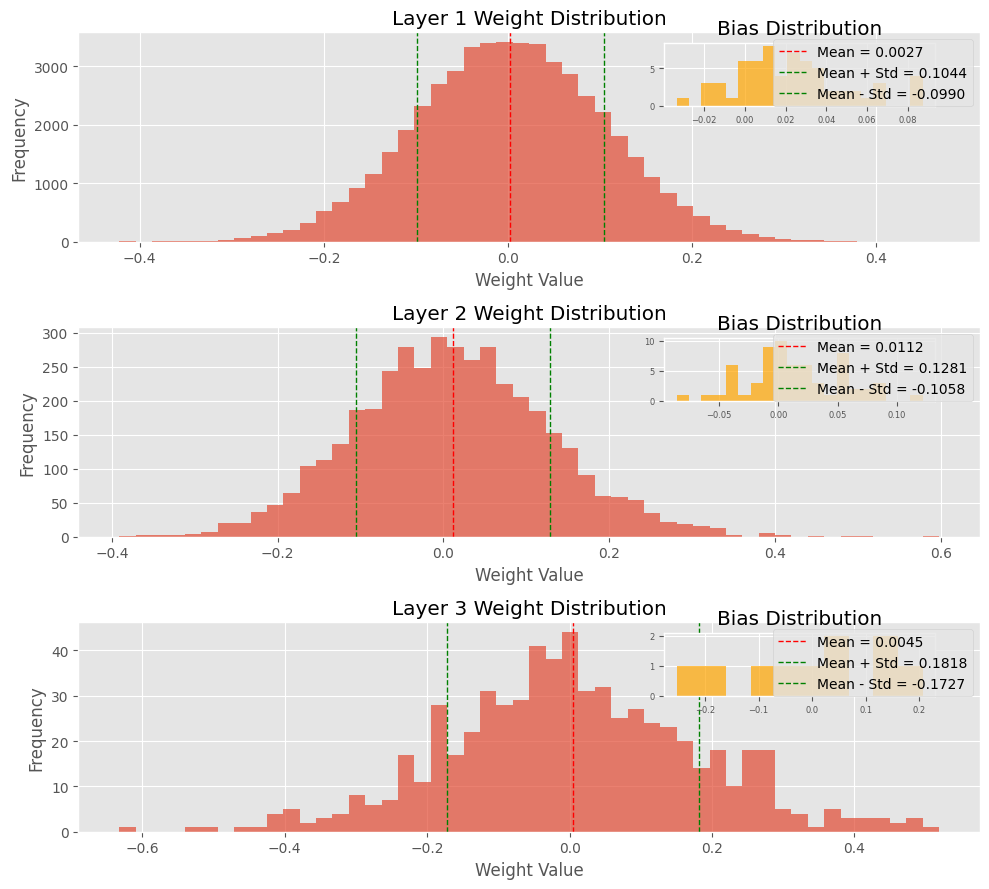

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing weight distributions...")
results_d1['model'].visualize_weight_distribution()

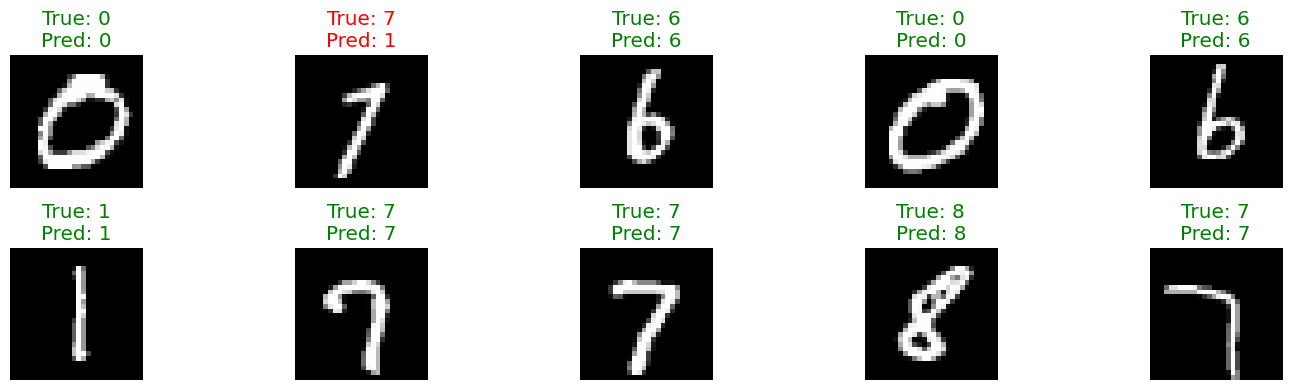

: 

: 

: 

: 

: 

In [ ]:
visualize_predictions(results_d1['model'], X_test, y_test, n_examples=10)

#### ii) 2 Layer

In [ ]:
# Set parameters for the model
hidden_layers = 2  # Depth of the model (1 hidden layer)
width_per_layer = 64  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_d2 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

# Print results
print(f"Test Accuracy: {results_d2['accuracy']:.4f}")
print(f"Training Time: {results_d2['training_time']:.2f} seconds")


Training model with 2 hidden layers, width: 64
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 55050
Epoch 1/10 - loss: 1.7470, val_loss: 1.0179
Epoch 2/10 - loss: 0.7137, val_loss: 0.5534
Epoch 3/10 - loss: 0.4862, val_loss: 0.4478
Epoch 4/10 - loss: 0.4136, val_loss: 0.3995
Epoch 5/10 - loss: 0.3753, val_loss: 0.3717
Epoch 6/10 - loss: 0.3497, val_loss: 0.3506
Epoch 7/10 - loss: 0.3307, val_loss: 0.3344
Epoch 8/10 - loss: 0.3151, val_loss: 0.3215
Epoch 9/10 - loss: 0.3017, val_loss: 0.3095
Epoch 10/10 - loss: 0.2900, val_loss: 0.2998
[==============================>]
Test accuracy: 0.9160
Training time: 7.19 seconds
Test Accuracy: 0.9160
Training Time: 7.19 seconds


: 

: 

: 

: 

: 


Evaluating on test set...


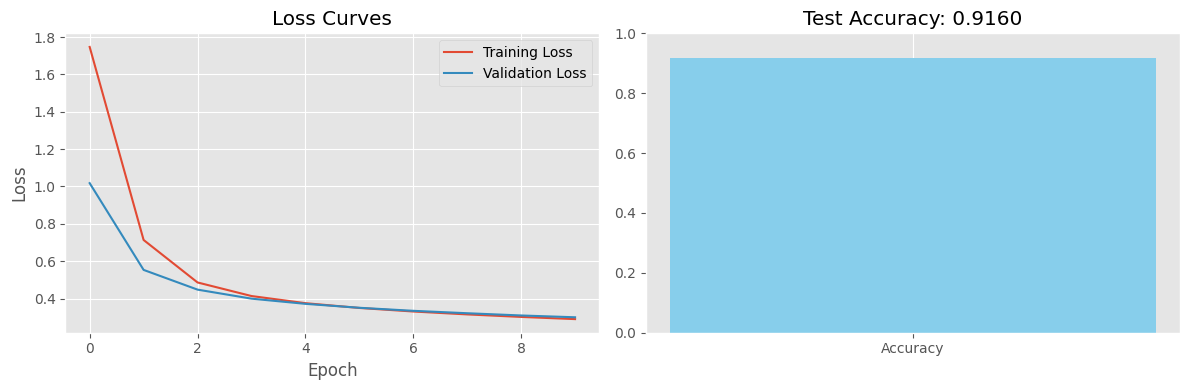

: 

: 

: 

: 

: 

In [ ]:
plot_training_history_and_accuracy(
    history=results_d2['history'],
    model=results_d2['model'],
    X_test=X_test,
    y_test=y_test
)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors


Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


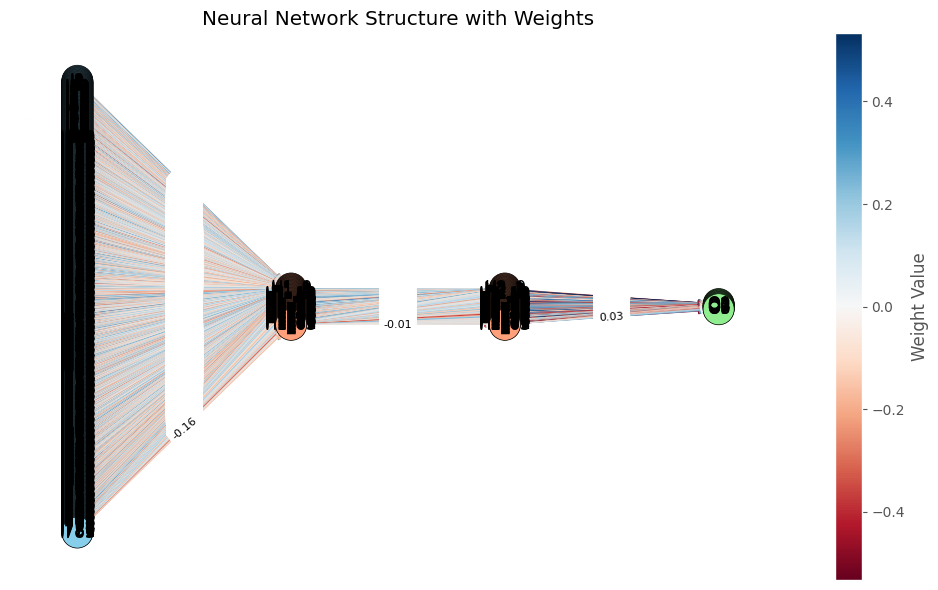

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing network structure...")
results_d2['model'].visualize_network(figsize=(10, 6))


Visualizing weight distributions...


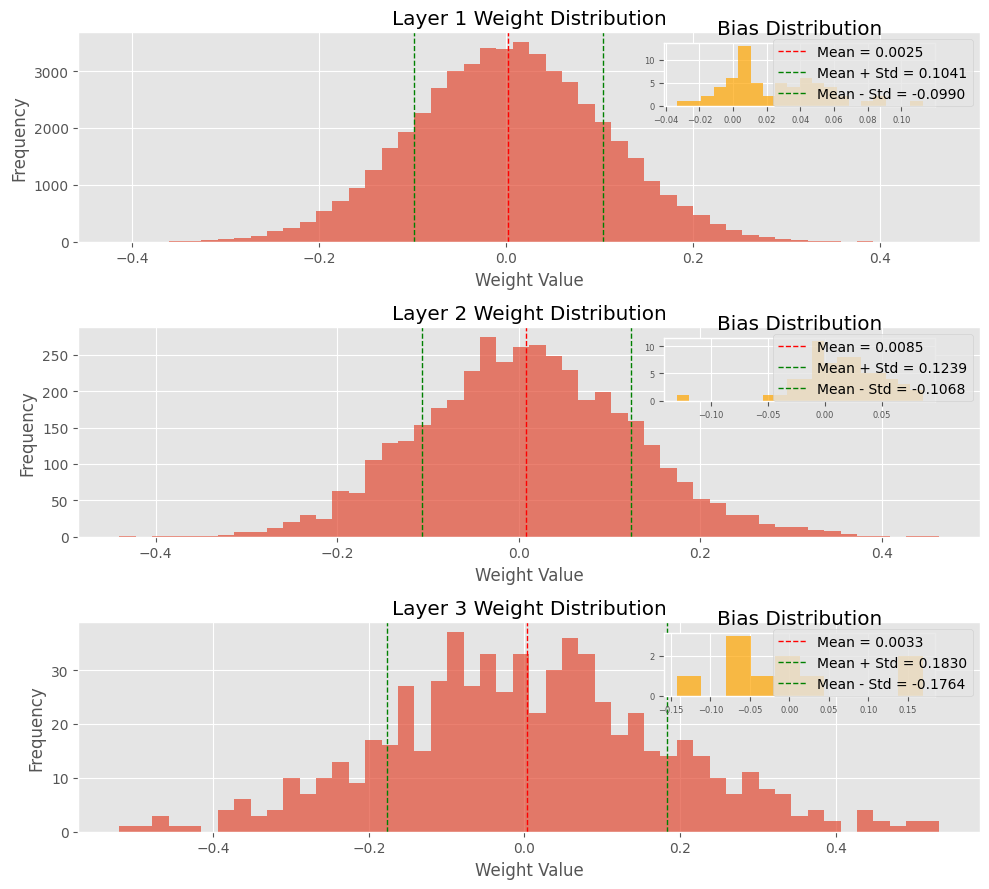

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing weight distributions...")
results_d2['model'].visualize_weight_distribution()

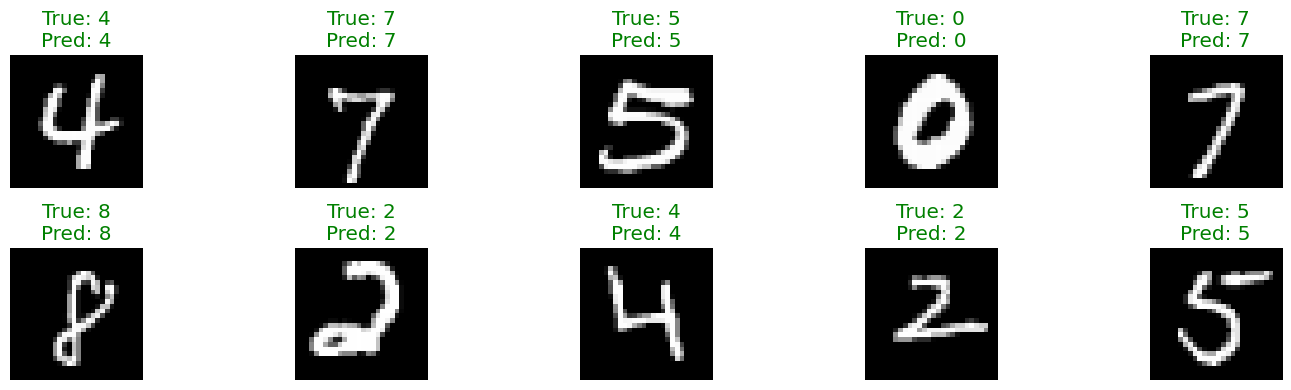

: 

: 

: 

: 

: 

In [ ]:
visualize_predictions(results_d2['model'], X_test, y_test, n_examples=10)

#### iii) 3 Layer

In [ ]:
# Set parameters for the model
hidden_layers = 3  # Depth of the model (1 hidden layer)
width_per_layer = 64  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_d3 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

# Print results
print(f"Test Accuracy: {results_d3['accuracy']:.4f}")
print(f"Training Time: {results_d3['training_time']:.2f} seconds")


Training model with 3 hidden layers, width: 64
Neural Network Architecture Summary
Total layers: 4

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 64 | Activation: ReLU | Parameters: 50240
  Layer 2: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 3: 64 → 64 | Activation: ReLU | Parameters: 4160
  Layer 4: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 59210
Epoch 1/10 - loss: 2.0923, val_loss: 1.6775
Epoch 2/10 - loss: 1.0784, val_loss: 0.7241
Epoch 3/10 - loss: 0.5958, val_loss: 0.5150
Epoch 4/10 - loss: 0.4599, val_loss: 0.4347
Epoch 5/10 - loss: 0.3966, val_loss: 0.3876
Epoch 6/10 - loss: 0.3595, val_loss: 0.3649
Epoch 7/10 - loss: 0.3343, val_loss: 0.3411
Epoch 8/10 - loss: 0.3143, val_loss: 0.3237
Epoch 9/10 - loss: 0.2975, val_loss: 0.3070
Epoch 10/10 - loss: 0.2828, val_loss: 0.2951
[==============================>]
Test accuracy: 0.9153
Training time: 19.31 seconds
Test Accuracy: 0.9153
Training Time: 19.31 seconds


: 

: 

: 

: 

: 


Evaluating on test set...


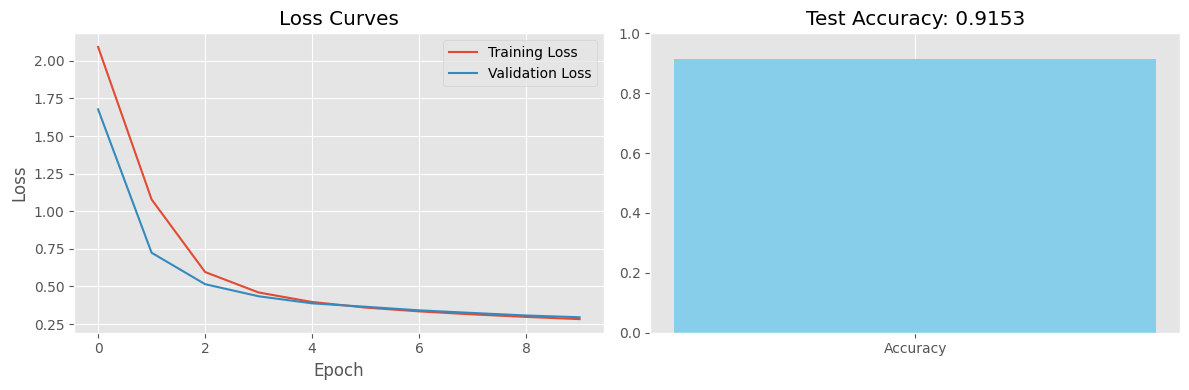

: 

: 

: 

: 

: 

In [ ]:
plot_training_history_and_accuracy(
    history=results_d3['history'],
    model=results_d3['model'],
    X_test=X_test,
    y_test=y_test
)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors
Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


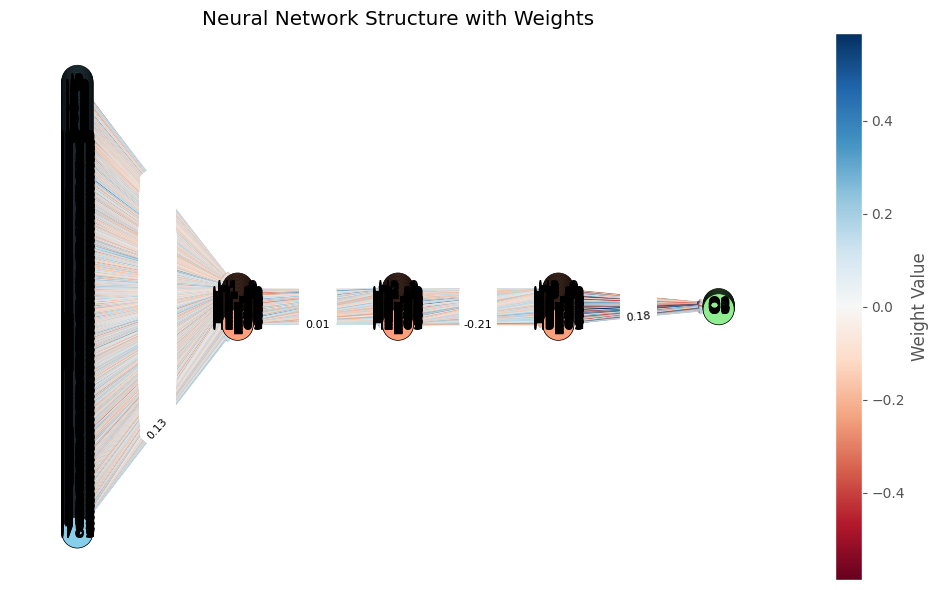

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing network structure...")
results_d3['model'].visualize_network(figsize=(10, 6))


Visualizing weight distributions...


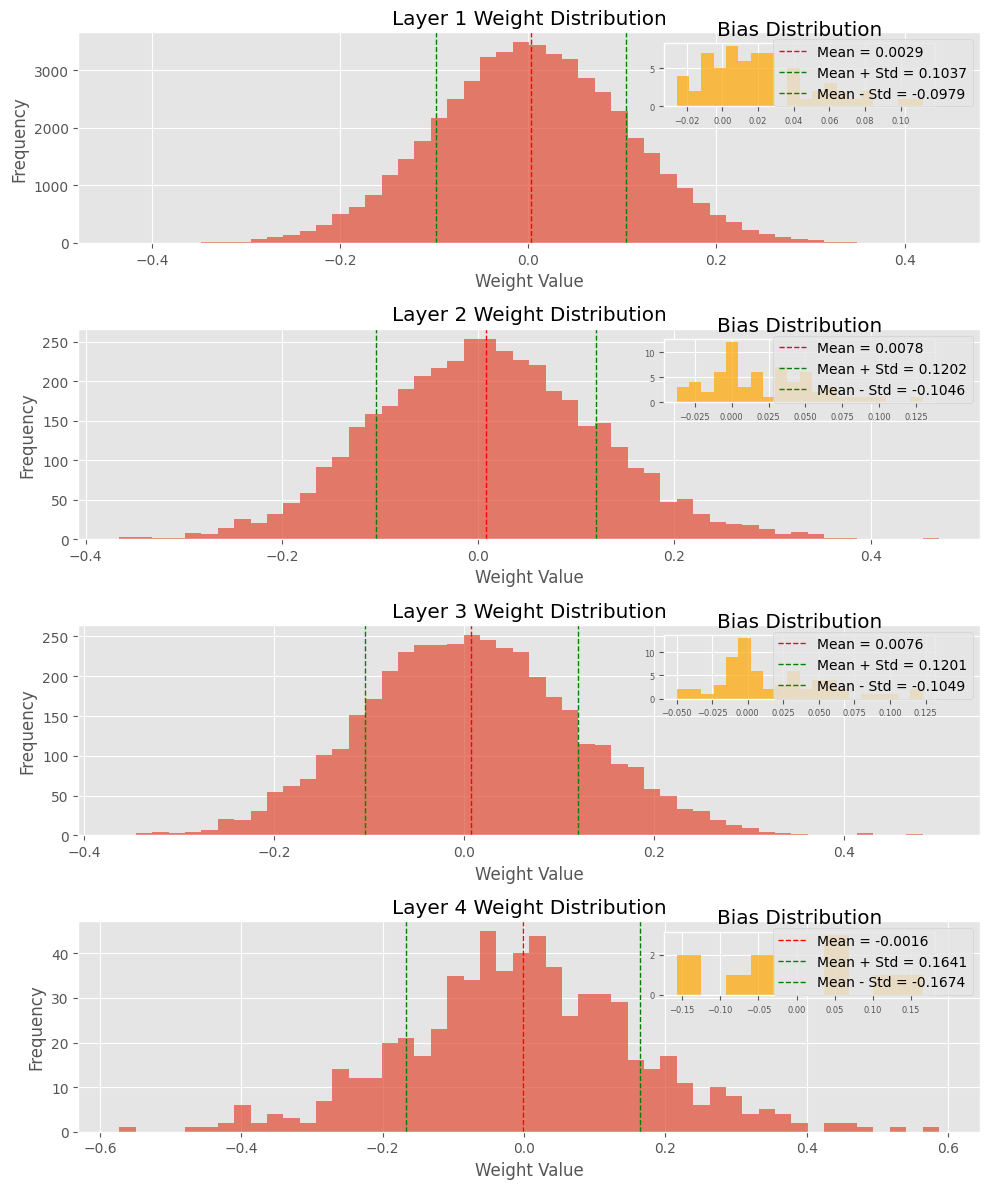

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing weight distributions...")
results_d3['model'].visualize_weight_distribution()

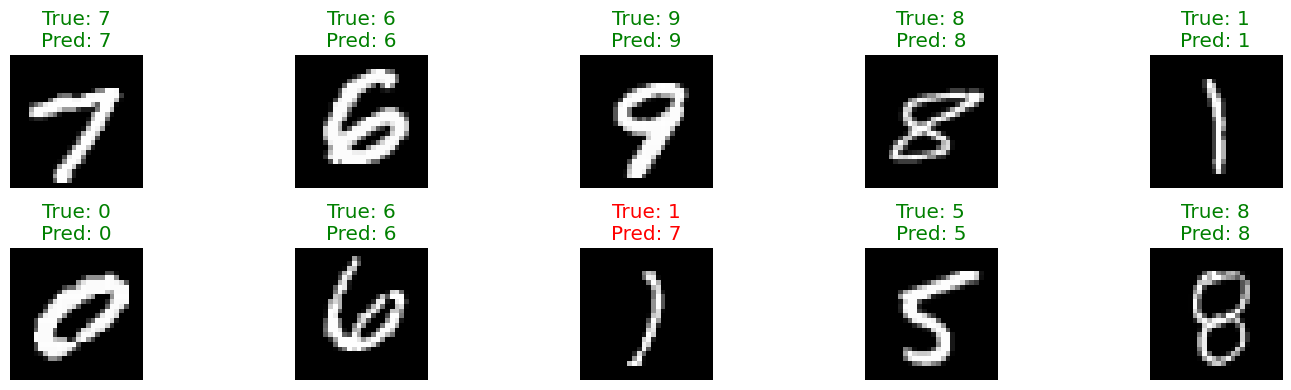

: 

: 

: 

: 

: 

In [ ]:
visualize_predictions(results_d3['model'], X_test, y_test, n_examples=10)

### II) Width

#### i) 32 Width per Layers

In [12]:
# Set parameters for the model
hidden_layers = 2  # Depth of the model (1 hidden layer)
width_per_layer = 32  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_w1 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

NameError: name 'train_and_evaluate' is not defined


Evaluating on test set...


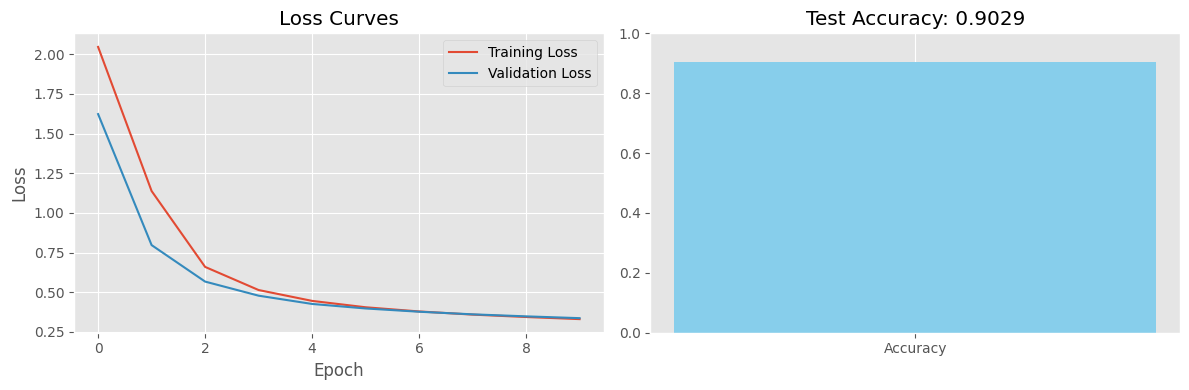

: 

: 

: 

: 

: 

In [ ]:
plot_training_history_and_accuracy(
    history=results_w1['history'],
    model=results_w1['model'],
    X_test=X_test,
    y_test=y_test
)


Visualizing network structure...
Adding edges with weights:


Draw network
Normalize weights to map to colors
Draw edges
Draw edge labels
Draw nodes
Draw labels
Draw legend


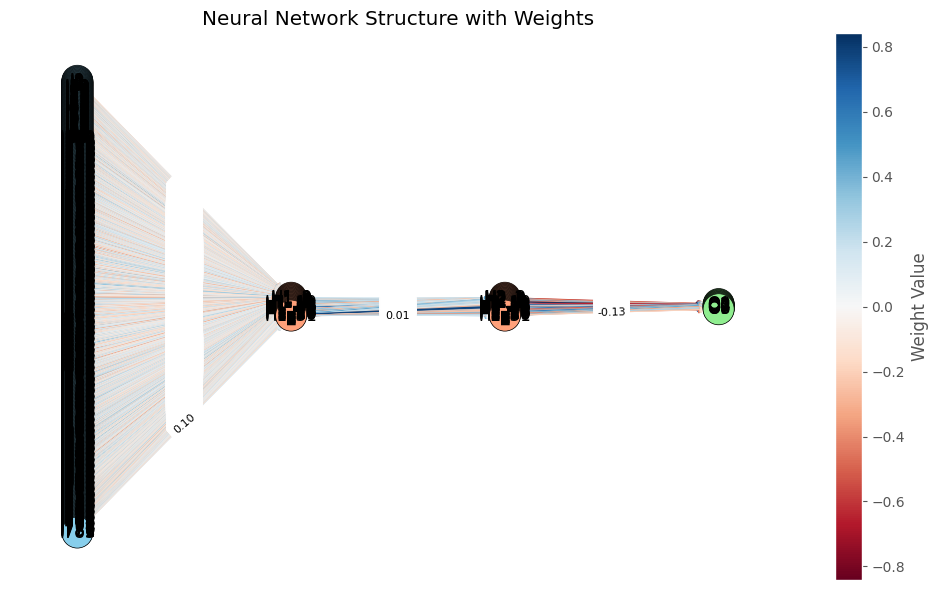

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing network structure...")
results_w1['model'].visualize_network(figsize=(10, 6))


Visualizing weight distributions...


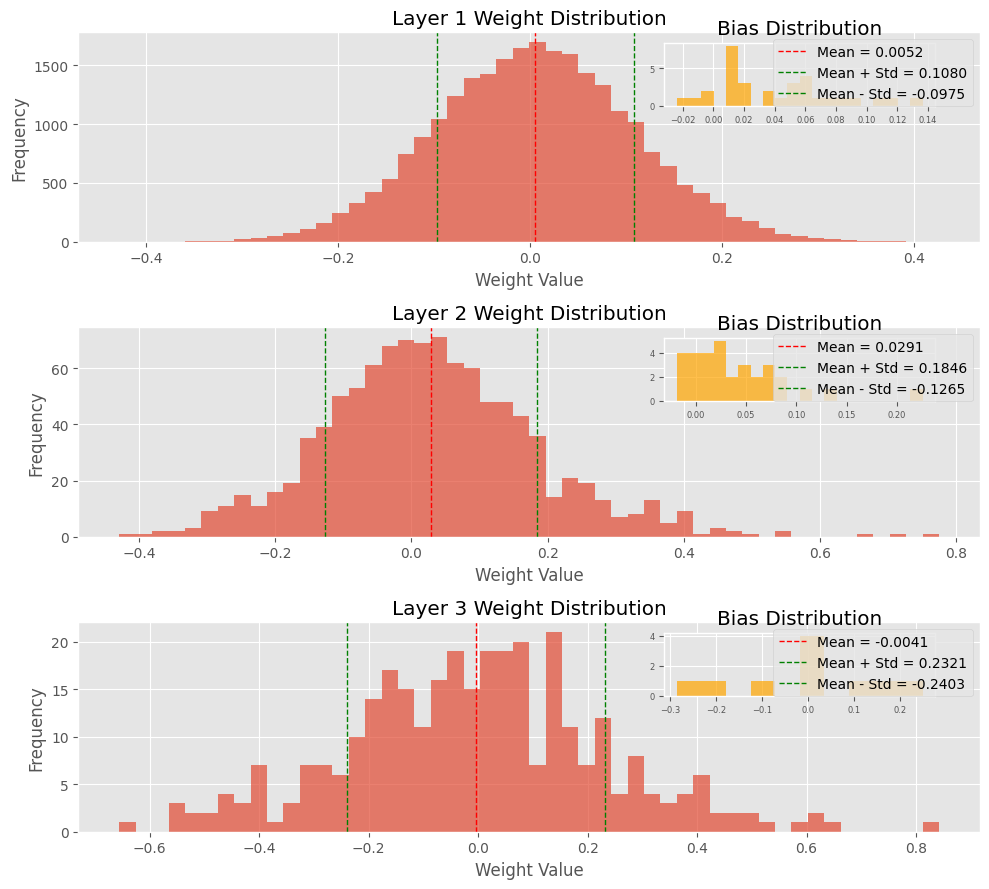

: 

: 

: 

: 

: 

In [ ]:
print("\nVisualizing weight distributions...")
results_w1['model'].visualize_weight_distribution()

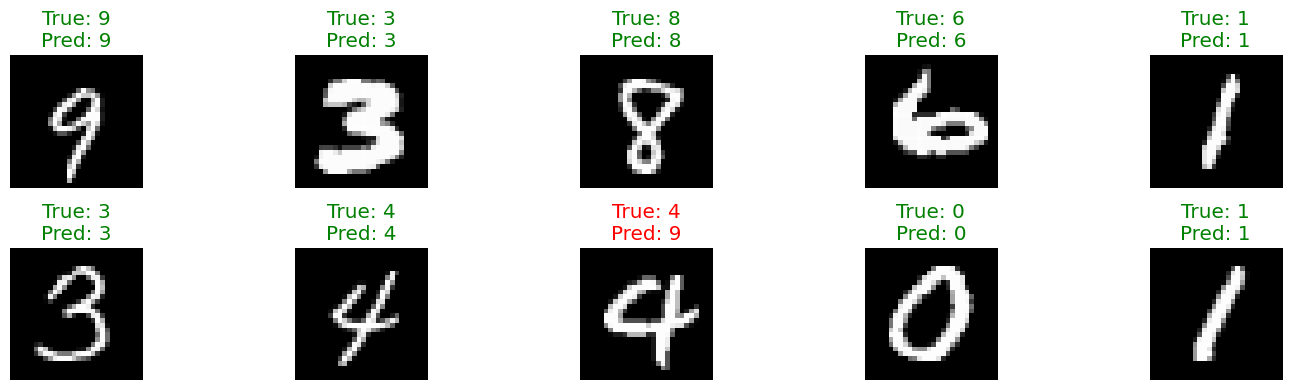

: 

: 

: 

: 

: 

In [ ]:
visualize_predictions(results_w1['model'], X_test, y_test, n_examples=10)

#### ii) 64 Width per Layers

In [13]:
# Set parameters for the model
hidden_layers = 2  # Depth of the model (1 hidden layer)
width_per_layer = 64  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_w2 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

NameError: name 'train_and_evaluate' is not defined

In [14]:
plot_training_history_and_accuracy(
    history=results_w2['history'],
    model=results_w2['model'],
    X_test=X_test,
    y_test=y_test
)

NameError: name 'plot_training_history_and_accuracy' is not defined

In [15]:
print("\nVisualizing network structure...")
results_w2['model'].visualize_network(figsize=(10, 6))


Visualizing network structure...


NameError: name 'results_w2' is not defined

In [16]:
print("\nVisualizing weight distributions...")
results_w2['model'].visualize_weight_distribution()


Visualizing weight distributions...


NameError: name 'results_w2' is not defined

In [17]:
visualize_predictions(results_w2['model'], X_test, y_test, n_examples=10)

NameError: name 'visualize_predictions' is not defined

#### iii) 128 Width per Layers

In [18]:
# Set parameters for the model
hidden_layers = 2  # Depth of the model (1 hidden layer)
width_per_layer = 128  # Width of the single hidden layer
epochs = 10  # Number of epochs
learning_rate = 0.01  # Learning rate
batch_size = 128  # Batch size

# Train and evaluate the model
results_w3 = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=hidden_layers,
    width_per_layer=width_per_layer,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size
)

NameError: name 'train_and_evaluate' is not defined

In [19]:
plot_training_history_and_accuracy(
    history=results_w3['history'],
    model=results_w3['model'],
    X_test=X_test,
    y_test=y_test
)

NameError: name 'plot_training_history_and_accuracy' is not defined

In [20]:
print("\nVisualizing network structure...")
results_w3['model'].visualize_network(figsize=(10, 6))


Visualizing network structure...


NameError: name 'results_w3' is not defined

In [21]:
print("\nVisualizing weight distributions...")
results_w3['model'].visualize_weight_distribution()


Visualizing weight distributions...


NameError: name 'results_w3' is not defined

In [22]:
visualize_predictions(results_w3['model'], X_test, y_test, n_examples=10)

NameError: name 'visualize_predictions' is not defined